<a href="https://colab.research.google.com/github/sera0911/Dacon/blob/main/%EA%B5%AC%EB%82%B4%EC%8B%9D%EB%8B%B9_%EC%8B%9D%EC%88%98_%EC%9D%B8%EC%9B%90_%EC%98%88%EC%B8%A1_AI/%EA%B5%AC%EB%82%B4%EC%8B%9D%EB%8B%B9_%EC%98%88%EC%B8%A1_LGBM%EB%AA%A8%EB%8D%B82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##식수인원 수치데이터로만 예측해보기

In [2]:
#모듈 불러오기

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

import warnings
warnings.filterwarnings(action='ignore')

The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [3]:
#데이터 불러오기

train = pd.read_csv('/content/drive/MyDrive/구내식당AI/train.csv')
test = pd.read_csv('/content/drive/MyDrive/구내식당AI/test.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              50 non-null     object 
 1   요일              50 non-null     object 
 2   본사정원수           50 non-null     int64  
 3   본사휴가자수          50 non-null     int64  
 4   본사출장자수          50 non-null     int64  
 5   본사시간외근무명령서승인건수  50 non-null     int64  
 6   현본사소속재택근무자수     50 non-null     float64
 7   조식메뉴            50 non-null     object 
 8   중식메뉴            50 non-null     object 
 9   석식메뉴            50 non-null     object 
dtypes: float64(1), int64(4), object(5)
memory usage: 4.0+ KB


##데이터 정제

1. 조식, 중식, 석식메뉴는 버리기 (drop)
2. 일자, 요일은 라벨 인코딩 (숫자형으로 변환)

In [6]:
#조식, 중식, 석식메뉴 drop

drops = ['조식메뉴', '중식메뉴', '석식메뉴']

train = train.drop(drops, axis=1)
test = test.drop(drops, axis=1)

In [7]:
#일자, 요일은 라벨 인코딩 (숫자형으로 변환)

train['월'] = pd.DatetimeIndex(train['일자']).month  #일자에서 달만 인덱스해서 넣어준다
test['월'] = pd.DatetimeIndex(test['일자']).month

train['일'] = pd.DatetimeIndex(train['일자']).day  #일자에서 일만 인덱스해서 넣어준다
test['일'] = pd.DatetimeIndex(test['일자']).day

In [8]:
weekday = {   #요일을 라벨을 붙여서 매핑해주기
    '월': 1,
    '화': 2,
    '수': 3,
    '목': 4,
    '금': 5
}

train['요일'] = train['요일'].map(weekday)
test['요일'] = test['요일'].map(weekday)

In [9]:
#데이터 확인
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,월,일
0,2016-02-01,1,2601,50,150,238,0.0,1039.0,331.0,2,1
1,2016-02-02,2,2601,50,173,319,0.0,867.0,560.0,2,2
2,2016-02-03,3,2601,56,180,111,0.0,1017.0,573.0,2,3
3,2016-02-04,4,2601,104,220,355,0.0,978.0,525.0,2,4
4,2016-02-05,5,2601,278,181,34,0.0,925.0,330.0,2,5


## 데이터 정제

- 휴가자, 재택근무자는 중식/석식에 참여하지 않을 것이므로 본사정원수에서 차감한다.

- 즉, 본사정원수 - 휴가자 - 재택근무자

- 식사참여율 = 식사계 / 식사가능자수

In [10]:
#식사가능자수 구하기

train['식사가능자수'] = train['본사정원수'] - train['본사휴가자수'] - train['현본사소속재택근무자수']
test['식사가능자수'] = test['본사정원수'] - test['본사휴가자수'] - test['현본사소속재택근무자수']

In [11]:
#식사 참여율 구하기

train['중식참여율'] = train['중식계'] / train['식사가능자수']
train['석식참여율'] = train['석식계'] / train['식사가능자수']

In [12]:
#최종 전처리 데이터 정리(필요한 칼럼만 데이터로 사용)

features = ['월', '일', '요일', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']
labels = ['중식계',	'석식계', '중식참여율', '석식참여율']

train = train[features+labels]
test = test[features]

In [13]:
train.head()

,월,일,요일,식사가능자수,본사출장자수,본사시간외근무명령서승인건수,중식계,석식계,중식참여율,석식참여율
0,2,1,1,2551.0,150,238,1039.0,331.0,0.407291,0.129753
1,2,2,2,2551.0,173,319,867.0,560.0,0.339867,0.219522
2,2,3,3,2545.0,180,111,1017.0,573.0,0.399607,0.225147
3,2,4,4,2497.0,220,355,978.0,525.0,0.391670,0.210252
4,2,5,5,2323.0,181,34,925.0,330.0,0.398192,0.142058


##EDA, 시각화, 상관관계분석


In [23]:
# 요일을 석식 rank에 맞춰 mapping한 요일(석식) 칼럼 만들기.

weekday_rank4dinner = {
    1: 1,
    2: 2,
    3: 5,
    4: 3,
    5: 4,
}

train['요일(석식)'] = train['요일'].map(weekday_rank4dinner)
test['요일(석식)'] = test['요일'].map(weekday_rank4dinner)

In [24]:
train.head()

,월,일,요일,식사가능자수,본사출장자수,본사시간외근무명령서승인건수,중식계,석식계,중식참여율,석식참여율,요일(석식)
0,2,1,1,2551.0,150,238,1039.0,331.0,0.407291,0.129753,1
1,2,2,2,2551.0,173,319,867.0,560.0,0.339867,0.219522,2
2,2,3,3,2545.0,180,111,1017.0,573.0,0.399607,0.225147,5
3,2,4,4,2497.0,220,355,978.0,525.0,0.391670,0.210252,3
4,2,5,5,2323.0,181,34,925.0,330.0,0.398192,0.142058,4


## 모델 만들기

In [25]:
#제출용 데이터 가져오기

submit = pd.read_csv('/content/drive/MyDrive/구내식당AI/sample_submission.csv')
submit.head()

,일자,중식계,석식계
0,2021-01-27,0,0
1,2021-01-28,0,0
2,2021-01-29,0,0
3,2021-02-01,0,0
4,2021-02-02,0,0


In [26]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from lightgbm import LGBMRegressor

# 과적합을 방지하기 위해 KFold 사용
kfold = KFold(n_splits=3, shuffle=True)

# LightGBM Regressor 사용
lgbmr = LGBMRegressor()

# 파라미터들 dict 형태로 정의
param = {
    'max_depth': [10, 15, -1], # 트리의 최대 깊이  / 과적합 제어
    'learning_rate': [0.1, 0.003], # 학습률
    'num_leaves': [64,128, 128], # 각 트리가 가질 수 있는 최대 리프의 개수 / 정확도 및 복잡률과 비례
    'n_estimators': [2000, 3000], # 반복 수행하는 트리의 개수
    }

# RandomizedSearchCV를 사용해 하이퍼 파라미터 최적화
lunch_model = RandomizedSearchCV(lgbmr, # 사용 모델
                                scoring='r2', # 학습에 사용할 손실 함수
                                n_iter=50, # 파라미터별 학습 수
                                param_distributions=param, # 파라미터
                                cv=kfold, # 폴드 값에 KFold 객체 할당
                                return_train_score=True, # 학습 결과 리턴
                                verbose=1)

x = train[['월', '일', '요일', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']]
y = train['중식계']

# GridSearch 하면서 모든 파라미터값들에 대해 학습 수행
lunch_model.fit(x, y)
print(lunch_model.best_score_, lunch_model.best_params_)
lunch_model = lunch_model.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  2.8min finished


0.7556948565336467 {'num_leaves': 64, 'n_estimators': 2000, 'max_depth': 10, 'learning_rate': 0.003}


In [27]:
#모델 적용시켜 예측하기

test_x = test[['월', '일', '요일', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']]
y_pred = lunch_model.predict(test_x)

In [28]:
print(y_pred)

[1069.71779918 1002.26478679  556.53502331 1262.6623516  1056.05660444
 1076.59106738 1036.32300792  702.00665611 1257.38585476 1064.39873475
  882.01715664 1319.38694945 1116.4334163  1105.40572528  918.52612642
  697.70356661 1301.25386969 1089.76617229  913.92390081  970.07831859
  653.55874324 1087.53241217 1098.91409877 1020.44678828  630.30383623
 1326.94984317 1105.61745556 1091.74652962 1030.59905658  677.90171804
 1313.47571102 1044.05902011 1085.12985431  941.57950985  668.78352353
 1272.39943736  975.44674462  975.653785    935.65616968  607.48551976
 1237.11537635 1036.98702416  987.4284704   898.1350163   662.95241053
 1199.16465247 1040.73738845 1010.27956491  930.53091169  667.50636186]


In [29]:
submit['중식계'] = y_pred

In [30]:
lgbmr = LGBMRegressor()

# 파라미터들 dict 형태로 정의
param = {
    'max_depth': [10, 15, -1], # 트리의 최대 깊이  / 과적합 제어
    'learning_rate': [0.1, 0.003], # 학습률
    'num_leaves': [64,128, 128], # 각 트리가 가질 수 있는 최대 리프의 개수 / 정확도 및 복잡률과 비례
    'n_estimators': [2000, 3000], # 반복 수행하는 트리의 개수
    }

# RandomizedSearchCV를 사용해 하이퍼 파라미터 최적화
dinner_model = RandomizedSearchCV(lgbmr, # 사용 모델
                                scoring='r2', # 학습에 사용할 손실 함수
                                n_iter=50, # 파라미터별 학습 수
                                param_distributions=param, # 파라미터
                                cv=kfold, # 폴드 값에 KFold 객체 할당
                                return_train_score=True, # 학습 결과 리턴
                                verbose=1)

x = train[['월', '일', '요일(석식)', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']]
y = train['석식계']

# GridSearch 하면서 모든 파라미터값들에 대해 학습 수행
dinner_model.fit(x, y)
print(dinner_model.best_score_, dinner_model.best_params_)
dinner_model = dinner_model.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  2.8min finished


0.5811249092953049 {'num_leaves': 64, 'n_estimators': 2000, 'max_depth': 10, 'learning_rate': 0.003}


In [31]:
#모델 적용시켜 예측하기

test_x = test[['월', '일', '요일(석식)', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']]
y_pred = dinner_model.predict(test_x)

In [32]:
submit['석식계'] = y_pred

In [33]:
#예측한 모델결과 저장하기

submit.to_csv('/content/drive/MyDrive/구내식당AI/LGBM_submit2.csv', index=False)

from google.colab import files

files.download('/content/drive/MyDrive/구내식당AI/LGBM_submit2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


결과 70.39732점

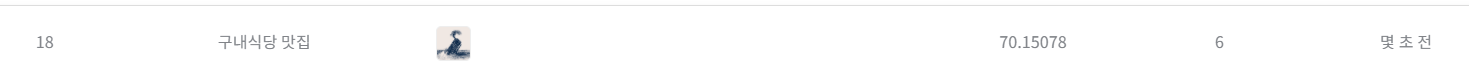

파라미터를 변경 했는데 기존보다 조금 더 점수가 떨어졌다

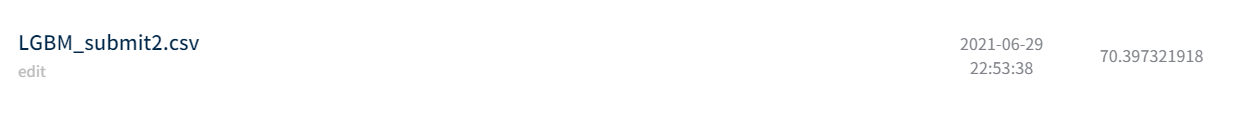